<a href="https://colab.research.google.com/github/felipe7leal/Quant-Algo/blob/main/Quantamental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://pbs.twimg.com/media/GBeQfmqWMAAN5E0?format=jpg&name=medium" width = "600">

# Code

## Aquisição dos Dados

In [ ]:
#Install

!pip install vectorbt

In [ ]:
#Import

import config
import pandas as pd
import numpy as np
import vectorbt as vbt
import re
import requests
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from datetime import datetime
from datetime import timedelta
from IPython.display import display

#import gate_api
#from binance.client import Client
#from web3 import Web3
#from web3.middleware import geth_poa_middleware
#from web3.exceptions import BadFunctionCallOutput

In [ ]:
#Funções
#Corretoras/Plataformas
def get_binance_balance(client):
    """Obtém o saldo da conta Binance."""

    try:
        # Obtenha o saldo da conta
        balances = client.get_account()["balances"]

        # Crie um DataFrame com os ativos
        df = pd.DataFrame(balances)

        # Converta as colunas free e locked em numérico para soma de saldo
        df["free"] = pd.to_numeric(df["free"])
        df["locked"] = pd.to_numeric(df["locked"])
        df["balance"] = df["free"] + df["locked"]

        # Filtre os ativos com saldo maior que zero
        df = df[df["balance"] > 0.00000000]

        # Drop das colunas
        df = df.drop(["locked", "free"], axis=1)

        # Cria identificação
        df['custody'] = 'Binance'

        return df
    except Exception as e:
        print(f"Erro ao obter saldo da Binance: {str(e)}")
        return pd.DataFrame()

def get_gate_balance(api_instance):
    """Obtém o saldo da conta Gate."""

    try:
        # Obtenha o saldo do portfólio
        result = api_instance.list_spot_accounts()

        # Crie uma lista de dicionários, cada um contendo 'currency' e 'available'
        data = [{'asset': account.currency, 'balance': account.available, 'custody' : 'Gate'} for account in result]

        # Transforme a lista em um DataFrame
        df = pd.DataFrame(data)

        return df
    except Exception as e:
        print(f"Erro ao obter saldo da Gate: {str(e)}")
        return pd.DataFrame()

def get_bsc_balance(w3, address, token_contract_address, token_contract_abi):
    """Obtém o saldo do token na Binance Smart Chain."""

    try:
        # Crie uma instância do contrato
        token_contract = w3.eth.contract(address=token_contract_address, abi=token_contract_abi)

        # Obtenha o saldo
        balance = token_contract.functions.balanceOf(address).call()

        # Converta o saldo para a unidade correta (a unidade padrão é geralmente muito pequena)
        decimals = token_contract.functions.decimals().call()
        balance = balance / (10 ** decimals)

        # Obtenha o ticker e nome do token
        token_symbol = token_contract.functions.symbol().call()

        # Crie um DataFrame
        data = [{'asset': token_symbol,'balance': balance, 'custody' : 'BSC'}]
        df = pd.DataFrame(data)

        return df
    except BadFunctionCallOutput as e:
        print(f"Erro ao obter saldo da BSC: {str(e)}")
        return pd.DataFrame()

def get_asset_balance():
    """Obtém o saldo total de ativos em todas as plataformas."""

    '''
    Binance
    c'''
    client = Client(config.binance_api_key, config.binance_api_secret)
    df_binance_asset = get_binance_balance(client)

    '''
    Gate
    '''
    # Configure a autenticação
    configuration = gate_api.Configuration()
    configuration.key = config.gate_api_key
    configuration.secret = config.gate_api_secret

    # Crie uma instância do cliente da API
    api_client = gate_api.ApiClient(configuration)
    api_instance = gate_api.SpotApi(api_client)
    df_gate_asset = get_gate_balance(api_instance)

    '''
    BSC
    '''
    # Conecte-se à BSC
    w3 = Web3(Web3.HTTPProvider('https://bsc-dataseed.binance.org/'))
    w3.middleware_onion.inject(geth_poa_middleware, layer=0)

    # Obtenha o DataFrame do saldo do token e o nome
    df_bsc_asset = get_bsc_balance(w3, config.light_wallet_address, config.light_smart_contract, config.light_abi_contract)

    '''
    Juntando dados
    '''

    # Concatene os dois DataFrames
    df_total_asset = pd.concat([df_gate_asset, df_binance_asset, df_bsc_asset])

    #Tratando tipo de dado para operações matemáticas
    df_total_asset['balance'] = pd.to_numeric(df_total_asset['balance'], errors='coerce')

    # Reset o índice do DataFrame resultante
    df_total_asset = df_total_asset.reset_index(drop=True)

    return df_total_asset

#CoinMarketCap
def get_cmc_endpoint(assets, endpoint):
    # Obtém dados do CoinMarketCap

    # Parâmetros:
    #   assets: Lista de símbolos de ativos
    #   endpoint: Endpoint da API CoinMarketCap

    try:
        headers = {
            'Accepts': 'application/json',
            'X-CMC_PRO_API_KEY': config.cmc_api_key,
        }

        # Converta a lista de ativos em uma string separada por vírgulas
        assets_str = ','.join(assets)

        # Endpoint para obter dados do CoinMarketCap
        url = f'https://pro-api.coinmarketcap.com/v2/cryptocurrency/{endpoint}?symbol={assets_str}'
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Adicionado para verificar erros HTTP

        data = response.json()
        return data
    except Exception as e:
        print(f"Erro ao obter dados do CoinMarketCap: {str(e)}")
        return None

def get_cmc_webscraping(slug):
    # Obtém dado de um ativo usando web scraping

    try:
        url = f'https://coinmarketcap.com/currencies/{slug}/'
        response = requests.get(url)
        response.raise_for_status()  # Adicionado para verificar erros HTTP

        soup = BeautifulSoup(response.text, 'html.parser')

        # Encontrar dados na página através do elemento HTML
        rating = soup.find('span', {'class': 'sc-f70bb44c-0 hDfvtp base-text'})
        qtd_watchlists = soup.find('span', {'class': 'sc-f70bb44c-0 emKKBj base-text'})
        cmc_rank = soup.find('span', {'class': 'sc-f70bb44c-0 dRraqO text'})
        ath = soup.find('div', class_='sc-f70bb44c-0 dVdjLB')

        return {
            'rating': rating.contents[0] if rating else None,
            'popularity_qtd_watchlists': qtd_watchlists.contents[0].replace(',', '') if qtd_watchlists else '',
            'popularity_cmc_rank': int(re.findall(r'^\d+', cmc_rank.text)[0]) if cmc_rank else None,
            'ath': float(ath.text.split('-')[0].replace('$', '').replace(',', '').strip())
        }
    except Exception as e:
        print(f"Erro ao obter dados de webscraping do CoinMarketCap para {slug}: {str(e)}")
        return None

def get_asset_info(assets):
    # Obtém informações de ativos de todas as plataformas

    # Primeiro, obtem dados básicos do CoinMarketCap
    # Em seguida, obtem dados de popularidade usando web scraping
    # Por fim, calcula o potencial de retorno

    try:
        # Obtenha dados básicos do CoinMarketCap
        data_info = get_cmc_endpoint(assets, 'info')
        if data_info is None:
            return pd.DataFrame()

        # Obtenha cotações do CoinMarketCap
        data_quotes = get_cmc_endpoint(assets, 'quotes/latest')
        if data_quotes is None:
            return pd.DataFrame()

        df = pd.DataFrame(assets, columns=['asset'])

        for asset in assets:
            logo = None
            name = None
            slug = None
            tag = None
            platform = None
            cmc_rank = None
            price = None
            percent_change_24h = None
            percent_change_7d = None
            percent_change_30d = None
            percent_change_90d = None
            market_cap = None

            for info in data_info['data'][asset]:
                # Para ativos que precisam de UCID - The Unified Cryptoasset ID
                if (len(data_info['data'][asset]) > 1 and info['id'] != config.cmc_id.get(info['symbol'])):
                    continue
                # Acessar os campos em data_info
                logo = info['logo']
                name = info['name']
                slug = info['slug']
                tag = info['tag-names']
                if info['platform'] is not None:
                    platform = info['platform']['name']
                else:
                    platform = None
            for quote in data_quotes['data'][asset]:
                # Para ativos que precisam de UCID - The Unified Cryptoasset ID
                if (len(data_quotes['data'][asset]) > 1 and quote['id'] != config.cmc_id.get(quote['symbol'])):
                    continue
                # Acessar os campos em data_quotes
                cmc_rank = quote['cmc_rank']
                price = quote['quote']['USD']['price']
                percent_change_24h = quote['quote']['USD']['percent_change_24h']
                percent_change_7d = quote['quote']['USD']['percent_change_7d']
                percent_change_30d = quote['quote']['USD']['percent_change_30d']
                percent_change_90d = quote['quote']['USD']['percent_change_90d']
                market_cap = quote['quote']['USD']['market_cap']

            # Adicionar os campos como novas colunas
            df.loc[df['asset'] == asset, 'logo'] = logo
            df.loc[df['asset'] == asset, 'name'] = name
            df.loc[df['asset'] == asset, 'slug'] = slug
            df.loc[df['asset'] == asset, 'platform'] = platform
            if isinstance(tag, list):
                df.loc[df['asset'] == asset, 'tag'] = ', '.join(tag)
            df.loc[df['asset'] == asset, 'cmc_rank'] = cmc_rank
            df.loc[df['asset'] == asset, 'price'] = price
            df.loc[df['asset'] == asset, 'percent_change_24h'] = percent_change_24h
            df.loc[df['asset'] == asset, 'percent_change_7d'] = percent_change_7d
            df.loc[df['asset'] == asset, 'percent_change_30d'] = percent_change_30d
            df.loc[df['asset'] == asset, 'percent_change_90d'] = percent_change_90d
            df.loc[df['asset'] == asset, 'market_cap'] = market_cap

        # Adicione a coluna 'CapCategory'
        # Large Cap (Grandes): Criptomoedas com MarketCap de US$ 10 bilhões ou mais. Mid Cap (Médias): Criptomoedas com MarketCap entre US$ 1 bilhão e US$ 10 bilhões. Small Cap (Pequenas): Criptomoedas com MarketCap abaixo de US$ 1 bilhão. Gemas: Criptomoedas com MarketCap abaixo de US$ 100 milhões.
        df['mc_category'] = df['market_cap'].apply(lambda market_cap:
                                                   'Large Cap' if market_cap >= 10e9 else (
                                                       'Mid Cap' if 1e9 <= market_cap < 10e9 else (
                                                           'Small Cap' if 100e6 <= market_cap < 1e9 else 'Gema')))

        for slug in df['slug']:
            # WebScraping para dados de Popularity não encontrado na documentação da API ou estão no plano pago.
            data = get_cmc_webscraping(slug)

            # The aggregate rating is a simple average of ratings collected from sources like Certik and Cyberscope.
            df.loc[df['slug'] == slug, 'rating'] = data['rating']

            # Number of watchlists on CoinMarketCap that include this cryptocurrency
            df.loc[df['slug'] == slug, 'popularity_qtd_watchlists'] = data['popularity_qtd_watchlists']

            # Ranking baseado na métrica de watchlists
            df.loc[df['slug'] == slug, 'popularity_cmc_rank'] = data['popularity_cmc_rank']

            # Preço máximo histórico da crypto
            df.loc[df['slug'] == slug, 'ath'] = data['ath']

        # Para calcular o potencial de retorno de uma criptomoeda, você pode usar a diferença entre o preço mais alto de todos os tempos (All Time High - ATH) e o preço atual.
        df['potencial_retorno'] = (((df['ath'] - df['price']) / df['price']) * 100).round(2)
        df['potencial_retorno_x'] = (df['potencial_retorno'] / 100).round(1).apply(lambda x: str(x) + 'x')

        # Converta os tipos das colunas
        df['cmc_rank'] = df['cmc_rank'].astype('Int32')
        df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
        df['popularity_qtd_watchlists'] = pd.to_numeric(df['popularity_qtd_watchlists'], errors='coerce')
        df['popularity_cmc_rank'] = df['popularity_cmc_rank'].astype('Int32')

        return df

    except Exception as e:
        print(f"Erro ao obter informações do CoinMarketCap: {str(e)}")
        return pd.DataFrame()

#Yahoo FInance
def get_asset_price(assets, data_type=None):
    df = pd.DataFrame()

    for asset in assets:
        try:
            if data_type == 'YTD':
                # Obtenha os dados do Yahoo Finance para o ano até a data
                stock_data = yf.download(f"{asset}-USD", start=f"{datetime.today().year}-01-01", end=datetime.today().strftime('%Y-%m-%d'))

                # Adicione uma coluna 'Asset' para identificar o ativo
                stock_data['asset'] = asset

                # Calcule a valorização year to date
                stock_data['percent_change_ytd'] = ((stock_data['Close'].iloc[-1] - stock_data['Open'].iloc[0]) / stock_data['Open'].iloc[0]) * 100

                # Pegue apenas a última linha com as colunas desejadas
                last = stock_data.tail(1)[['asset', 'percent_change_ytd']]

            elif data_type == '1Y':
                # Obtenha os dados do Yahoo Finance para o último ano
                one_year_ago = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')
                stock_data = yf.download(f"{asset}-USD", start=one_year_ago, end=datetime.today().strftime('%Y-%m-%d'))

                # Adicione uma coluna 'Asset' para identificar o ativo
                stock_data['asset'] = asset

                # Calcule a valorização de 1 ano
                stock_data['percent_change_1y'] = ((stock_data['Close'].iloc[-1] - stock_data['Open'].iloc[0]) / stock_data['Open'].iloc[0]) * 100

                # Pegue apenas a última linha com as colunas desejadas
                last = stock_data.tail(1)[['asset', 'percent_change_1y']]

            else:
                # Obtenha os dados do Yahoo Finance para o intervalo semanal
                stock_data = yf.download(f"{asset}-USD", interval="1wk")

                # Adicione uma coluna 'Asset' para identificar o ativo
                stock_data['symbol'] = asset

                last = stock_data

            # Concatene os dados ao DataFrame principal
            df = pd.concat([df, last])

        except Exception as e:
            print(f"Erro ao obter dados para {asset}: {e}")

    return df

In [ ]:
'''
binance.client não funciona nesse ambiente.
Devido a restrições regulatórias, a Binance pode não funcionar em certas regiões, incluindo os servidores do Google Colab.

# Função para obter o balanço nas corretoras e carteiras
df_crypto_asset = get_asset_balance()

# Tratamento de moeda FIAT USD e BRL
assets = [asset for asset in set(df_crypto_asset['asset']) if asset != 'BRL']

# Função para obter informações dos ativos
#df_asset_info = get_asset_info(assets)

# Realize o merge (join) entre df_crypto_asset e df_asset_info usando a coluna 'asset'
#df_crypto_asset_info = pd.merge(df_crypto_asset, df_asset_info, on='asset', how='left')
'''

assets = ["ATLAS", "ILV", "SCRT", "SDAO", "HERO", "ERG", "KYL", "QSP", "BNB", "ENJ", "XLM", "WAVES", "THETA", "IOTX", "VET", "MATIC", "ATOM", "ONE", "CHZ", "HBAR", "XTZ", "COTI", "SOL", "MKR", "SNX", "DOT",
          "KSM", "UNI", "AVAX", "CAKE", "AAVE", "FIL", "INJ", "AUDIO", "GRT", "CELO", "1INCH", "CKB", "AR", "AGIX", "FLOW", "RAY", "GALA", "LIGHT", "WOZX", "BTC", "ETH", "ADA", 'LINK']

df_crypto_asset_info = get_asset_info(assets)

# Merge dos DataFrames utilizando a coluna 'asset' como chave
df_crypto_asset_info = df_crypto_asset_info.merge(get_asset_price(assets, 'YTD')[['asset', 'percent_change_ytd']], on='asset', how='left')
df_crypto_asset_info = df_crypto_asset_info.merge(get_asset_price(assets, '1Y')[['asset', 'percent_change_1y']], on='asset', how='left')

# Crie a coluna com saldo em dólar
#df_crypto_asset_info['balance_usd'] = df_crypto_asset_info['balance'] * df_crypto_asset_info['price']

# Removendo saldos zerados
#df_crypto_asset_info = df_crypto_asset_info[df_crypto_asset_info['balance_usd'] > 1]

# Cria colunas de classe e sub classe dos ativos.
df_crypto_asset_info['class'] = df_crypto_asset_info['asset'].map(lambda x: config.asset_dict[x]['Class'])
df_crypto_asset_info['sub_class'] = df_crypto_asset_info['asset'].map(lambda x: config.asset_dict[x]['Subclass'])

# Ordenar o DataFrame pelas colunas especificadas
column_order = [
    'asset', 'name', 'slug', 'platform', 'mc_category', 'class', 'sub_class', 'market_cap', 'potencial_retorno', 'potencial_retorno_x',
    'ath', 'price', 'percent_change_24h', 'percent_change_7d', 'percent_change_30d', 'percent_change_90d', 'percent_change_1y', 'percent_change_ytd',
    'rating', 'popularity_qtd_watchlists', 'popularity_cmc_rank', 'cmc_rank', 'logo', 'tag'
] #, 'balance', 'balance_usd', 'custody'
df_crypto_asset_info = df_crypto_asset_info[column_order]

# Função para obter dados históricos de preço no formato OHLC
df_crypto_price =  get_asset_price(df_crypto_asset_info['asset'])


# Analytics

## Retornos %

In [ ]:
# Calcula a média de 'percent_change_1y' agrupada por 'platform', 'class', 'sub_class'
df_grouped_mean = df_crypto_asset_info.groupby(['class', 'sub_class'])['percent_change_1y'].mean().reset_index()

# Cria um gráfico de barras para visualizar a classe
fig = px.bar(df_grouped_mean, x='class', y='percent_change_1y', color='sub_class', barmode='group',
             labels={'percent_change_1y':'Média de percent_change_1y', 'sub_class':'Sub Classe', 'class':'Classe'},
             title='Média de Retoro Anual % por Setor')
fig.show()


> Retorno anual por categoria de capitalização de mercado

In [ ]:
# Crie os DataFrames filtrados sem estilização
df_large_cap = df_crypto_asset_info[df_crypto_asset_info['mc_category'] == 'Large Cap'].percent_change_1y.describe().to_frame()
df_mid_cap = df_crypto_asset_info[df_crypto_asset_info['mc_category'] == 'Mid Cap'].percent_change_1y.describe().to_frame()
df_small_cap = df_crypto_asset_info[df_crypto_asset_info['mc_category'] == 'Small Cap'].percent_change_1y.describe().to_frame()
df_gema = df_crypto_asset_info[df_crypto_asset_info['mc_category'] == 'Gema'].percent_change_1y.describe().to_frame()

# Concatena os DataFrames em um único DataFrame, usando `keys` para especificar os nomes das colunas
df_all = pd.concat([df_large_cap, df_mid_cap, df_small_cap, df_gema], axis=1, keys=['Large Cap', 'Mid Cap', 'Small Cap', 'Gema'])

# Aplique o estilo ao DataFrame concatenado
df_all = df_all.style.format(precision=2)

# Exiba o DataFrame estilizado
display(df_all)

,Large Cap,Mid Cap,Small Cap,Gema
,percent_change_1y,percent_change_1y,percent_change_1y,percent_change_1y
count,6.00,16.00,19.00,8.00
mean,182.95,232.21,75.81,39.67
std,204.97,626.10,172.84,115.97
min,15.94,-7.70,-34.83,-87.37
25%,76.47,44.75,5.81,-30.24
50%,118.79,72.61,25.61,-5.53
75%,179.61,118.12,60.99,98.07
max,581.94,2569.97,693.35,257.00


> Maiores retornos do portfólio no período de 365 dias

In [ ]:
df_high_returns = df_crypto_asset_info[(df_crypto_asset_info['percent_change_1y'] > df_crypto_asset_info['percent_change_1y'].quantile(0.75))]
df_high_returns[['asset','name', 'class', 'mc_category','potencial_retorno_x', 'ath', 'price',
                 'percent_change_24h', 'percent_change_7d','percent_change_30d', 'percent_change_90d', 'percent_change_1y', 'percent_change_ytd']].sort_values('percent_change_1y', ascending=False)

,asset,name,class,mc_category,potencial_retorno_x,ath,price,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_90d,percent_change_1y,percent_change_ytd
32,INJ,Injective,DeFi,Mid Cap,0.0x,44.61000,42.615170,17.898042,6.779389,125.314858,481.162748,2569.968751,2.379087
41,RAY,Raydium,DeFi,Small Cap,12.6x,16.93000,1.241470,6.193161,-9.510474,83.897972,662.978471,693.354007,-6.754082
22,SOL,Solana,Blockchain,Large Cap,1.7x,260.06000,97.469787,8.404687,-9.738177,31.834776,339.939974,581.941029,-12.054110
39,AGIX,SingularityNET,AI Economy,Small Cap,5.6x,1.86000,0.279881,7.268405,-15.913302,-15.319376,67.372171,368.438198,-18.982791
43,LIGHT,Light DeFi,DeFi,Gema,95.2x,0.03078,0.000320,-2.919090,-7.250167,-31.946399,-6.601090,257.000000,-9.296084
23,MKR,Maker,DeFi,Mid Cap,2.5x,6339.02000,1806.101403,1.516054,8.901781,25.423268,31.063027,216.294785,2.922300
28,AVAX,Avalanche,Blockchain,Large Cap,3.1x,146.22000,35.988247,6.776636,-12.612404,12.460812,276.675455,186.417926,-12.783159
45,BTC,Bitcoin,Blockchain,Large Cap,0.5x,68789.63000,46963.884414,6.788283,7.952452,6.671933,71.095954,159.187908,3.932957
3,SDAO,SingularityDAO,DeFi,Gema,12.5x,6.61000,0.489436,10.317273,-6.286078,-16.975698,51.194875,152.832287,-13.723546
34,GRT,The Graph,Data Economy,Mid Cap,15.8x,2.88000,0.171200,3.641456,-21.500903,-0.054588,110.286777,152.000000,-7.700000


> Filtrado por melhores fundamentos, de acordo com esses critérios: Market cap alto, bom rating e alto número de watchlists

In [ ]:
df_strong_fundamentals = df_crypto_asset_info[(df_crypto_asset_info['mc_category'] == 'Large Cap') &
                                              (df_crypto_asset_info['rating'] > df_crypto_asset_info['rating'].quantile(0.5)) &
                                              (df_crypto_asset_info['popularity_qtd_watchlists'] > df_crypto_asset_info['popularity_qtd_watchlists'].quantile(0.75))]
df_strong_fundamentals[['asset','name', 'class', 'mc_category','potencial_retorno_x', 'ath', 'price',
                        'percent_change_24h', 'percent_change_7d','percent_change_30d', 'percent_change_90d', 'percent_change_1y', 'percent_change_ytd']].sort_values('percent_change_1y', ascending=False)

,asset,name,class,mc_category,potencial_retorno_x,ath,price,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_90d,percent_change_1y,percent_change_ytd
28,AVAX,Avalanche,Blockchain,Large Cap,3.1x,146.22,35.988247,6.776636,-12.612404,12.460812,276.675455,186.417926,-12.783159
45,BTC,Bitcoin,Blockchain,Large Cap,0.5x,68789.63,46963.884414,6.788283,7.952452,6.671933,71.095954,159.187908,3.932957
46,ETH,Ethereum,Blockchain,Large Cap,1.1x,4891.70,2339.113484,5.203227,0.255172,-0.832986,49.137777,75.834347,-2.628463
8,BNB,BNB,Blockchain,Large Cap,1.3x,690.93,306.040267,0.993870,-2.351954,27.527764,46.706173,15.937660,-3.039635


> Maiores retornos Small Caps e Gemas

In [ ]:
df_high_returns = df_crypto_asset_info[(df_crypto_asset_info['mc_category'] == 'Small Cap') &
                                       (df_crypto_asset_info['percent_change_1y'] > df_crypto_asset_info['percent_change_1y'].quantile(0.75))]
df_high_returns[['asset','name', 'class', 'mc_category','potencial_retorno_x', 'ath', 'price',
                        'percent_change_24h', 'percent_change_7d','percent_change_30d', 'percent_change_90d', 'percent_change_1y', 'percent_change_ytd']].sort_values('percent_change_1y', ascending=False)

,asset,name,class,mc_category,potencial_retorno_x,ath,price,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_90d,percent_change_1y,percent_change_ytd
41,RAY,Raydium,DeFi,Small Cap,12.6x,16.93,1.241470,6.193161,-9.510474,83.897972,662.978471,693.354007,-6.754082
39,AGIX,SingularityNET,AI Economy,Small Cap,5.6x,1.86,0.279881,7.268405,-15.913302,-15.319376,67.372171,368.438198,-18.982791


In [ ]:
# Maiores retornos Gemas
df_high_returns = df_crypto_asset_info[(df_crypto_asset_info['mc_category'] == 'Gema') &
                                       (df_crypto_asset_info['percent_change_1y'] > df_crypto_asset_info['percent_change_1y'].quantile(0.75))]
df_high_returns[['asset','name', 'class', 'mc_category','potencial_retorno_x', 'ath', 'price',
                        'percent_change_24h', 'percent_change_7d','percent_change_30d', 'percent_change_90d', 'percent_change_1y', 'percent_change_ytd']].sort_values('percent_change_1y', ascending=False)

,asset,name,class,mc_category,potencial_retorno_x,ath,price,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_90d,percent_change_1y,percent_change_ytd
43,LIGHT,Light DeFi,DeFi,Gema,95.2x,0.03078,0.000320,-2.919090,-7.250167,-31.946399,-6.601090,257.000000,-9.296084
3,SDAO,SingularityDAO,DeFi,Gema,12.5x,6.61000,0.489436,10.317273,-6.286078,-16.975698,51.194875,152.832287,-13.723546


> Principais oportunidades de valorização potencial, do precço atual até ao último all time high.

In [ ]:
df_potential_returns = df_crypto_asset_info[(df_crypto_asset_info['potencial_retorno'] > df_crypto_asset_info['potencial_retorno'].quantile(0.75))]
df_potential_returns[['asset','name', 'class', 'mc_category', 'potencial_retorno','potencial_retorno_x', 'ath', 'price',
                        'percent_change_24h', 'percent_change_7d','percent_change_30d', 'percent_change_90d', 'percent_change_1y', 'percent_change_ytd']].sort_values('potencial_retorno', ascending=False)

,asset,name,class,mc_category,potencial_retorno,potencial_retorno_x,ath,price,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_90d,percent_change_1y,percent_change_ytd
44,WOZX,Efforce,Energy,Gema,60076.60,600.8x,3.62000,0.006016,4.642818,2.732110,-14.364034,-76.453111,-87.372427,-4.044793
6,KYL,Kylin,Data Economy,Gema,22063.49,220.6x,2.20000,0.009926,2.828121,0.088012,-0.481849,22.331776,-23.579232,-1.378957
7,QSP,Quantstamp,Cyber Security,Gema,16275.28,162.8x,0.86640,0.005291,-8.133588,1.150972,16.436446,-46.033598,-50.232358,18.261760
43,LIGHT,Light DeFi,DeFi,Gema,9515.65,95.2x,0.03078,0.000320,-2.919090,-7.250167,-31.946399,-6.601090,257.000000,-9.296084
4,HERO,Metahero,Metaverse,Gema,8030.75,80.3x,0.25180,0.003097,0.409974,-16.159011,-0.996735,25.929085,-15.000000,-16.600000
40,FLOW,Flow,Blockchain,Mid Cap,5551.40,55.5x,46.16000,0.816789,7.429035,-14.561292,-5.526873,90.981197,8.770773,-16.464889
0,ATLAS,Star Atlas,Metaverse,Gema,4963.64,49.6x,0.27730,0.005476,4.122117,-8.602921,-17.747117,284.623179,79.813020,-7.052081
31,FIL,Filecoin,Data Economy,Mid Cap,3972.37,39.7x,237.24000,5.825598,4.250945,-23.941599,11.298809,81.795578,70.151538,-18.977664
1,ILV,Illuvium,Metaverse,Small Cap,3218.89,32.2x,2868.95000,86.442967,8.747098,-7.656619,-21.133359,116.004507,99.620313,-12.443171
42,GALA,Gala,Metaverse,Small Cap,3057.27,30.6x,0.83670,0.026501,6.250731,-16.819929,-19.167450,96.948067,5.767578,-18.688599


> **Efeito Rede**, entender se as altcoins mais populares (com base na quantidade de watchlists) também são as que tiveram os maiores retornos no último ano.

In [ ]:
import numpy as np

df = df_crypto_asset_info[['asset', 'market_cap', 'percent_change_1y', 'popularity_qtd_watchlists']].copy()

df.loc[:, 'log_market_cap'] = np.log(df['market_cap'] + 1)

fig = px.scatter(df, x='percent_change_1y', y='popularity_qtd_watchlists', color='asset', size='log_market_cap',
                 labels={'percent_change_1y':'Retorno Percentual em 1 Ano', 'popularity_qtd_watchlists':'Quantidade de Watchlists', 'log_market_cap':'Log do Market Cap'},
                 title='Relação entre Retorno Percentual em 1 Ano, Quantidade de Watchlists e Log do Market Cap')
fig.show()

## Asset location

In [ ]:
# Crie uma lista com os nomes dos ecossistemas
ecosystems = df_crypto_asset_info['platform'].unique()

# Crie um DataFrame com a contagem de ativos por ecossistema
df_ecosystems = df_crypto_asset_info.groupby('platform').size().reset_index(name='count')

# Crie o gráfico de rosca
fig = px.pie(df_ecosystems, values='count', names='platform', hole=0.5)

# Defina o título do gráfico
fig.update_layout(title='Exposição por Ecossistema')

# Exiba o gráfico
fig.show()

In [ ]:
# Crie uma lista com as categorias de capitalização de mercado
mc_categories = df_crypto_asset_info['mc_category'].unique()

# Crie um DataFrame com a contagem de ativos por categoria de capitalização de mercado
df_mc_categories = df_crypto_asset_info.groupby('mc_category').size().reset_index(name='count')

# Crie o gráfico de pizza
fig = px.pie(df_mc_categories, values='count', names='mc_category')

# Defina o título do gráfico
fig.update_layout(title='Exposição por Market Cap')

# Exiba o gráfico
fig.show()

In [ ]:
# Crie um DataFrame com a contagem de ativos por classe e subclasse
df_classes = df_crypto_asset_info.groupby(['class', 'sub_class']).size().reset_index(name='count')

# Ordene o DataFrame por classe
df_classes = df_classes.sort_values('class', ascending=True)

# Crie o gráfico de barras
fig = px.bar(df_classes, x='class', y='count', color='sub_class')

# Defina o título do gráfico
fig.update_layout(title='Composição de Ativos por Classe e Subclasse')

# Exiba o gráfico
fig.show()

### Análise Setorial e Narrativas

> Eclesiastes‬ ‭11:1‭-‬2‬, 6 ‭NTLH‬‬

> [1] Empregue o seu dinheiro em bons negócios e com o tempo você terá o seu lucro. [2] Aplique-o em vários lugares e em negócios diferentes porque você não sabe que crise poderá acontecer no mundo.
[6] Semeie de manhã e também de tarde porque você não sabe se todas as sementes crescerão bem, nem se uma crescerá melhor do que a outra.



---
---

> Nuvem de palavras das tags mais comuns em criptoativos do portfólio





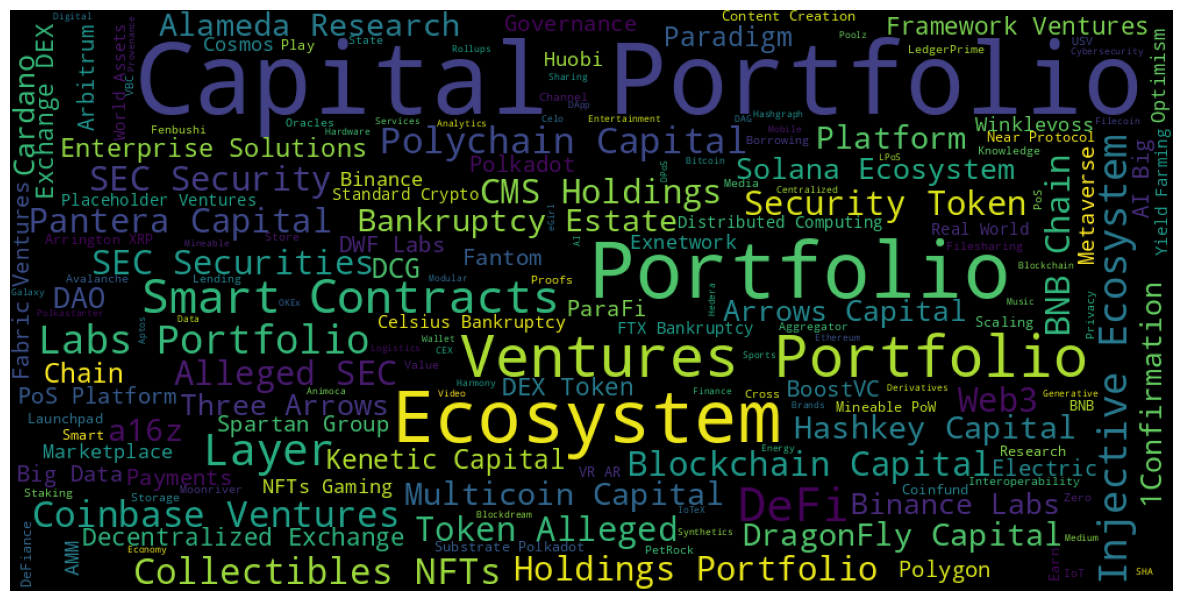

In [ ]:
df_crypto_asset_info['tag'].fillna('', inplace=True)
all_tags = ','.join(df_crypto_asset_info['tag'])
wordcloud = WordCloud(width = 1000, height = 500).generate(all_tags)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Blockchain

A tecnologia blockchain é um sistema de registro descentralizado e transparente que permite transações seguras e eficientes. Tem o potencial de revolucionar diversas indústrias, incluindo finanças, gerenciamento da cadeia de suprimentos, saúde e muito mais. A tese de investimento para o setor blockchain baseia-se na crença de que essa tecnologia continuará a crescer e ser adotada por empresas e governos em todo o mundo.

As soluções de Layer 1, como Ethereum e Cardano, são a base para o desenvolvimento de aplicativos descentralizados e contratos inteligentes. Essas soluções têm potencial para melhorar a escalabilidade, segurança e funcionalidade, atraindo mais desenvolvedores e usuários.

As soluções de Layer 2 visam melhorar a escalabilidade e reduzir os custos de transação. Essas soluções podem ajudar a resolver os desafios de escalabilidade dos protocolos de camada 1, permitindo transações mais rápidas e baratas.

---

---




<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/1.png" width = "70">

Tese - Bitcoin é uma nova classe de ativo que nunca existiu na história da humanidade, pois combina três classes de ativos: **cash** (transações), **venture investments** (investimentos de risco) e **store of value** (reserva de valor).





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'BTC'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
45,BTC,Bitcoin,None,Large Cap,Blockchain,Store Of Value,4.5,4408915,30,1


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'BTC']
data['MA100'] = data['Close'].rolling(window=100).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Bitcoin'),go.Scatter(x=data.index, y=data['MA100'], mode='lines', name='MA100')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/1027.png" width = "70">

Tese - É a **segunda maior** criptomoeda em capitalização de mercado, base do crescente **ecossistema DeFi** e **líder** em valor total bloqueado (**TVL**). Sua ampla comunidade de desenvolvedores e a quantidade de projetos em sua blockchain fortalecem seu **efeito de rede**, especialmente na **web 3.0**. Atraído por sua **narrativa deflacionária e ESG**, tem recebido atenção de investidores institucionais e grandes corporações que buscam aprovação de ETF spot.

In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'ETH'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
46,ETH,Ethereum,None,Large Cap,Blockchain,Layer 1,4.6,3236222,48,2


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'ETH']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Ethereum'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/1839.png" width = "70">

Tese - Binance Coin (BNB) é a criptomoeda nativa da Binance, uma das maiores bolsas de criptomoedas do mundo. A utilidade do BNB dentro do ecossistema Binance, a queima periódica de tokens e o crescimento do ecossistema Binance são fatores que tornam o BNB um investimento atraente. Além disso, a crescente adoção da Binance e seus serviços pode impulsionar a demanda por BNB. A Binance também usa parte de seus lucros para recomprar e queimar tokens BNB, aumentando potencialmente sua escassez e valor ao longo do tempo.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'BNB'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
8,BNB,BNB,None,Large Cap,Blockchain,CEX,4.4,2054174,64,4


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'BNB']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='BNB'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/5426.png" width = "70">

Tese - O modelo de negócios de Solana gira em torno de fornecer uma plataforma blockchain escalável e segura para desenvolvedores e empresas construírem aplicações descentralizadas. Solana visa atrair desenvolvedores oferecendo alto rendimento, baixa latência e taxas de transação baixas, o que pode permitir uma ampla gama de casos de uso e impulsionar a adoção da plataforma. Além disso, Solana pode explorar parcerias, colaborações e soluções empresariais para aprimorar ainda mais seu modelo de negócios





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'SOL'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
22,SOL,Solana,None,Large Cap,Blockchain,Layer 1,4.0,1963137,67,5


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'SOL']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Solana'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/2010.png" width = "70">

Tese - A tese de investimento para Cardano gira em torno da ideia de criar um sistema financeiro sustentável e inclusivo, aproveitando a tecnologia blockchain. Cardano é uma plataforma blockchain que visa fornecer uma infraestrutura segura e escalável para o desenvolvimento de aplicações descentralizadas e contratos inteligentes. A plataforma utiliza uma arquitetura em camadas e um mecanismo de consenso de prova de participação para atingir esses objetivos.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'ADA'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
47,ADA,Cardano,None,Large Cap,Blockchain,Layer 1,4.2,2366208,58,8


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'ADA']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Cardano'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/5805.png" width = "70">

Tese - Protocolo de consenso único chamado Avalanche, que oferece alta escalabilidade, taxas de transação baixas e tempos de confirmação rápidos. Avalanche é uma plataforma descentralizada que visa fornecer uma infraestrutura de alto desempenho para o desenvolvimento de aplicações descentralizadas e soluções blockchain empresariais. A plataforma gera receita através de vários mecanismos, como taxas de transação e recompensas de staking. O diferencial do Avalanche é seu protocolo de consenso, que permite alto rendimento e baixa latência, diferenciando-o de mecanismos de consenso tradicionais como Proof-of-Work (PoW) ou Proof-of-Stake (PoS).





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'AVAX'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
28,AVAX,Avalanche,Avalanche,Large Cap,Blockchain,Layer 1,4.4,1003291,98,9


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'AVAX']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Avalanche'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/6636.png" width = "70">

Tese - Polkadot é uma plataforma blockchain que visa criar uma infraestrutura escalável e segura para a web descentralizada. Seu modelo de negócios é baseado em fornecer uma plataforma para desenvolvedores construírem seus próprios projetos blockchain. O token nativo do Polkadot, DOT, é usado para governança, staking e bonding. O diferencial do Polkadot é sua abordagem única para a interoperabilidade, permitindo que múltiplos blockchains se conectem e se comuniquem entre si.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'DOT'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
25,DOT,Polkadot,BNB,Mid Cap,Blockchain,Substrate,4.1,1558992,75,11


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'DOT']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Polkadot'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/4642.png" width = "70">

Tese - Hedera é uma rede pública descentralizada que visa fornecer uma plataforma segura e escalável para a construção de aplicações descentralizadas. A tese de investimento para Hedera é baseada em oferecer uma alternativa mais eficiente e sustentável às plataformas blockchain tradicionais. O modelo de negócios do Hedera é baseado em fornecer uma plataforma para desenvolvedores construírem e implantarem suas aplicações. Hedera se destaca por utilizar um algoritmo de consenso único chamado Hashgraph e por seu foco na adoção empresarial e conformidade regulatória.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'HBAR'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
19,HBAR,Hedera,None,Mid Cap,Blockchain,Layer 1,4.0,544206,147,33


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'HBAR']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Hedera'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/4558.png" width = "70">

Tese - FLOW é uma plataforma blockchain desenvolvida pela Dapper Labs, criadores do CryptoKitties. A tese de investimento para FLOW é fornecer uma infraestrutura blockchain escalável e amigável para desenvolvedores para a construção de aplicações descentralizadas e ativos digitais. O modelo de negócios do FLOW é baseado em fornecer uma plataforma blockchain robusta e eficiente que pode suportar aplicações de alto desempenho e permitir experiências de usuário perfeitas. FLOW se destaca por sua abordagem única para escalabilidade, utilizando um algoritmo de consenso chamado Proof of Stake (PoS) combinado com uma técnica de sharding chamada “executors” para alcançar alto rendimento e baixa latência.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'FLOW'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
40,FLOW,Flow,Ethereum,Mid Cap,Blockchain,Layer 1,4.0,225546,263,58


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'FLOW']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Flow'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/2011.png" width = "70">

Tese - Tezos é uma plataforma blockchain que visa fornecer uma infraestrutura segura e descentralizada para a construção de contratos inteligentes e aplicações descentralizadas. A tese de investimento para Tezos é baseada na ideia de auto-emenda, onde o protocolo Tezos pode evoluir e se atualizar sem a necessidade de um hard fork. O modelo de negócios do Tezos é baseado em operar como uma rede descentralizada, semelhante a outras plataformas blockchain. O diferencial do Tezos é sua característica de auto-emenda, que permite atualizações de protocolo sem hard forks contenciosos. Além disso, Tezos enfatiza a segurança e a verificação formal, o que envolve provar matematicamente a correção dos contratos inteligentes, reduzindo o risco de vulnerabilidades e bugs.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'XTZ'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
20,XTZ,Tezos,Tezos,Small Cap,Blockchain,Layer 1,4.2,401182,179,69


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'XTZ']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Tezos'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/5567.png" width = "70">

Tese - CELO é uma plataforma blockchain que visa tornar as ferramentas e serviços financeiros mais acessíveis para pessoas ao redor do mundo. A plataforma utiliza um mecanismo de consenso de prova de participação para proteger a rede e validar transações. CELO se destaca por seu foco em acessibilidade **mobile-first**, criando um ecossistema descentralizado onde os usuários têm controle sobre seus dados e ativos financeiros, priorizando escalabilidade e taxas de transação baixas, e tem um forte foco em **impacto social** e **inclusão financeira**.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'CELO'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
35,CELO,Celo,Celo,Small Cap,Blockchain,Mobile,4.2,198389,285,127


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'CELO']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Celo'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/5034.png" width = "70">

Tese - Kusama é uma plataforma descentralizada construída na rede Polkadot que visa fornecer uma infraestrutura escalável e interoperável para aplicações blockchain. O modelo de negócios do Kusama é centrado em fornecer uma plataforma para desenvolvedores construírem e implantarem seus próprios projetos blockchain. Kusama também tem sua própria criptomoeda nativa chamada KSM, que é usada para governança, staking e como meio de troca dentro da rede. O diferencial do Kusama é sua natureza experimental e foco na inovação, servindo como um campo de testes para novas ideias e tecnologias, permitindo que os desenvolvedores experimentem e iterem em seus projetos antes de implantá-los na rede Polkadot mais estável.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'KSM'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
26,KSM,Kusama,None,Small Cap,Blockchain,Substrate,4.0,277080,223,137


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'KSM']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Kusama'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/1274.png" width = "70">

Tese - Waves é uma plataforma blockchain que visa facilitar a criação e gestão de aplicações descentralizadas e tokens personalizados. O modelo de negócios do Waves é centrado em gerar receita através de várias fontes, como as taxas coletadas de transações e criação de tokens em sua plataforma. Waves também tem sua própria criptomoeda nativa chamada Waves, que é usada para transações e como meio de angariar fundos através de Ofertas Iniciais de Moedas (ICOs) na plataforma. O diferencial do Waves é seu foco em fornecer uma interface e ferramentas amigáveis ao usuário, sua escalabilidade, a criação de tokens personalizados e a interoperabilidade com outras plataformas blockchain.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'WAVES'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
11,WAVES,Waves,Waves,Small Cap,Blockchain,Layer 1,4.0,192544,295,162


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'WAVES']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Waves'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/4948.png" width = "70">

Tese - A tese de investimento para a Nervos Network gira em torno da crença de que uma arquitetura em camadas pode resolver as limitações das plataformas de blockchain existentes. Nervos Network se destaca por seu foco em interoperabilidade e sustentabilidade, visando criar uma plataforma universal que pode interagir com outros blockchains e sistemas legados. Além disso, o Nervos Network introduz um modelo econômico único chamado “Common Knowledge Base” (CKB), que alinha os interesses dos usuários, desenvolvedores e mineradores para garantir a sustentabilidade de longo prazo da rede.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'CKB'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
37,CKB,Nervos Network,None,Small Cap,Blockchain,Interoperability,4.4,139328,371,281


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'CKB']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Nervos Network'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/1762.png" width = "70">

Tese -  A tese de investimento do Ergo gira em torno do crescimento potencial e adoção do DeFi, bem como a capacidade da equipe de desenvolver soluções inovadoras no setor. O modelo de negócios do Ergo é centrado em seu token nativo, o ERG, usado para governança, staking e participação em várias pools de agricultura de rendimento. O que diferencia o Ergo de outros projetos é seu foco na simplicidade e experiência do usuário, visando tornar o DeFi acessível a um público mais amplo. Além disso, o Ergo é construído na blockchain Ergo, que utiliza o modelo UTXO e incorpora recursos criptográficos avançados para maior segurança e privacidade.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'ERG'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
5,ERG,Ergo,None,Small Cap,Blockchain,Layer 1,4.0,97595,458,319


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'ERG']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Ergo'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/5604.png" width = "70">

Tese - Este projeto está intimamente ligado aos conceitos **Web3**, especificamente à privacidade de dados. Minha tese é que a regulamentação pode desencadear a adoção e a demanda por proteção contra a intervenção governamental. O projeto se orgulha de uma tecnologia superior em comparação com seus pares e ganhou tração institucional através de parcerias com Chainlink e The Graph, tornando-o minha escolha para “**Privacy Coins**”.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'SCRT'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
2,SCRT,Secret,Osmosis,Small Cap,Blockchain,Privacy,4.0,133566,380,321


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'SCRT']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Secret'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### DeFi

A tese de investimento DeFi (Decentralized Finance) foca no potencial disruptivo das finanças descentralizadas. O setor, em crescimento, está atraindo investidores que acreditam que DeFi irá capturar uma parcela significativa da indústria financeira. Baseado em blockchain e contratos inteligentes para automação de transações, DeFi oferece o potencial de fornecer serviços financeiros como empréstimos, negociações e ganho de juros sem a necessidade de intermediários.


---
---

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/7083.png" width = "70">

Tese - Uniswap é um protocolo de troca descentralizado na blockchain Ethereum, permitindo a negociação direta de tokens ERC-20. Com o crescimento do mercado DeFi, Uniswap se destaca como uma **plataforma líder** e maior (TVL) entre (DEX), beneficiando-se do aumento do volume de negociação. Seu modelo de formador de mercado automatizado incentiva provedores de liquidez, criando um ecossistema autossustentável. A crescente base de usuários e os **efeitos de rede** fortalecem sua posição no mercado.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'UNI'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
27,UNI,Uniswap,Ethereum,Mid Cap,DeFi,DEX,4.4,680740,125,23


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'UNI']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Uniswap'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/7226.png" width = "70">

Tese - Na minha perspectiva, DeFi veio para ficar e continuará sendo um dos **setores mais promissores** do mercado de criptomoedas.
O projeto INJ é um projeto promissor no espaço DeFi, e está focado na **interoperabilidade**, que acredito ser essencial para o futuro do DeFi e do mercado de criptomoedas como um todo.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'INJ'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
32,INJ,Injective,Injective,Mid Cap,DeFi,DEX,4.6,230146,256,24


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'INJ']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Injective'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/512.png" width = "70">

Tese - Plataforma blockchain que facilita transações transfronteiriças rápidas e de baixo custo. Com parcerias estabelecidas, como a IBM, e foco na inclusão financeira, atraiu a atenção de instituições financeiras. Sua arquitetura permite transações rápidas e alta escalabilidade. A Fundação de Desenvolvimento Stellar, uma organização sem fins lucrativos, apoia o crescimento da rede Stellar. Apesar da concorrência de outras plataformas blockchain e sistemas financeiros tradicionais, Stellar se destaca.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'XLM'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
10,XLM,Stellar,None,Mid Cap,DeFi,Payment,4.0,896779,106,26


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'XLM']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Stellar'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/1518.png" width = "70">

Tese - Maker é uma organização autônoma descentralizada (DAO) construída na blockchain Ethereum. É um token de governança que alimenta a plataforma MakerDAO, permitindo aos usuários gerar e gerenciar a stablecoin DAI. Maker tem sólidos fundamentos e boa posição no mercado, sugerindo um bom desempenho a longo prazo. Em termos de tecnologia, o projeto possui tecnologia avançada e inovadora, um sinal positivo para suas perspectivas futuras.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'MKR'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
23,MKR,Maker,Ethereum,Mid Cap,DeFi,DAO Currency,4.5,194540,291,47


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'MKR']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Maker'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/7278.png" width = "70">

Tese - Aave é uma plataforma de empréstimos descentralizada na Ethereum. Oferece uma alternativa aos serviços financeiros tradicionais, permitindo acesso à liquidez sem intermediários. Introduziu **empréstimos flash**, abrindo possibilidades para arbitragem e operações financeiras complexas. Foca na experiência do usuário e segurança, e suporta uma variedade de ativos, incluindo criptomoedas populares e stablecoins.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'AAVE'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
30,AAVE,Aave,Ethereum,Mid Cap,DeFi,Lending,4.3,430292,170,54


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'AAVE']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Aave'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/2586.png" width = "70">

Tese - Synthetix é um protocolo DeFi que permite a criação e negociação de ativos sintéticos na Ethereum. O token SNX é usado como garantia para a emissão desses ativos. A plataforma se destaca pela introdução de empréstimos flash e pela liquidez agrupada, eliminando a necessidade de contrapartes nas conversões.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'SNX'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
24,SNX,Synthetix,Ethereum,Mid Cap,DeFi,DEX,4.5,233331,254,64


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'SNX']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Synthetix'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/7186.png" width = "70">

Tese - CAKE é o token nativo da Pancakeswap, uma bolsa descentralizada na Binance Smart Chain (BSC). A plataforma permite aos usuários negociar criptomoedas de maneira descentralizada e eficiente, além de participar da agricultura de rendimento. Como alternativa de menor custo às DEXs baseadas em Ethereum, a Pancakeswap aproveita a escalabilidade e as taxas de transação mais baixas da BSC. Os usuários também podem fornecer liquidez em pools específicos e ganhar tokens CAKE como recompensa.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'CAKE'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
29,CAKE,PancakeSwap,Ethereum,Small Cap,DeFi,DEX,4.4,669119,126,85


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'CAKE']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='PancakeSwap'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/8104.png" width = "70">

Tese - Protocolo DeFi na Ethereum que agrega liquidez de várias exchanges descentralizadas para fornecer aos usuários a melhor rota de negociação. A tese de investimento do 1INCH gira em torno de sua capacidade de fornecer aos usuários uma maneira eficiente de negociar criptomoedas e participar da Farming. O que diferencia o 1INCH de outras plataformas é seu algoritmo avançado e roteamento inteligente, que garante que os usuários obtenham os melhores preços possíveis para suas negociações.




In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == '1INCH'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
36,1INCH,1inch Network,Ethereum,Small Cap,DeFi,DEX,4.6,321307,206,112


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == '1INCH']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='1inch Network'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/8526.png" width = "70">

Tese - Criptomoeda Raydium se concentra em fornecer um protocolo de liquidez descentralizado na blockchain Solana aos usuários. Busca oferecer transações rápidas e de baixo custo, além de oportunidades eficientes de provisão de liquidez e farming. O projeto se destaca ao aproveitar a alta capacidade e as baixas taxas da blockchain Solana, proporcionando uma experiência de usuário contínua.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'RAY'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
41,RAY,Raydium,Solana,Small Cap,DeFi,DEX,NaN,139913,370,151


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'RAY']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Raydium'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/3992.png" width = "70">

Tese - Protocolo de pagamento descentralizado. Com a ‘Coin of the Internet’, qualquer empresa ou governo pode emitir suas próprias criptomoedas. COTI combina as vantagens da tecnologia de registro distribuído (DLT) com as do mecanismo de pagamento tradicional, visando se tornar a solução de pagamento descentralizada padrão na indústria global de comércio. As transações envolvendo COTI se tornam ainda mais rápidas com um número crescente de usuários, o que torna a COTI uma solução melhor e mais eficiente para servir o comércio global como mecanismo de pagamento. Além disso, a COTI é o único ativo digital a oferecer uma alternativa convincente aos sistemas de pagamento existentes, pois é a primeira moeda digital a levar em conta a mediação, um aspecto essencial de qualquer rede de pagamentos bem-sucedida





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'COTI'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
21,COTI,COTI,Ethereum,Gema,DeFi,Payment,3.8,206750,278,409


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'COTI']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='COTI'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/9638.png" width = "70">

Tese - **Meu top 1** é a SingularityDAO. Estudando para um MBA em análise de big data, essa criptomoeda chamou minha atenção. Estou explorando como os algoritmos de IA usam dados para melhorar o desempenho e li o whitepaper do projeto para entender sua infraestrutura. Acredito em seu potencial, considerando o sucesso da **Renaissance Technologies** e a alta demanda por **fundos de hedge quantitativos** na indústria americana. Na minha visão, **democratizar** o acesso a uma **ferramenta tecnológica** que antes era exclusiva dos principais players de Wall Street é tão significativo quanto a revolução do Bitcoin como uma alternativa ao sistema monetário atual.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'SDAO'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
3,SDAO,SingularityDAO,Ethereum,Gema,DeFi,Asset Management,4.3,52572,674,576


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'SDAO']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='SingularityDAO'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/12058.png" width = "70">

Tese - Apesar do ceticismo dos **investimentos ESG**, acredito no setor de “**Impact Tokens**” e sou defensor do financiamento de um futuro mais sustentável. Além disso, é um projeto com forte potencial de investimento. O projeto da Light DeFi é ambicioso e pretende desenvolver uma usina fotovoltaica com capacidade de produção de até 480 MegaWatts.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'LIGHT'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
43,LIGHT,Light DeFi,BNB,Gema,DeFi,Impact Token,3.9,7373,2538,4778


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'LIGHT']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Light DeFi'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### Data Economy

A economia baseada em dados (Data Economy) está crescendo. Em 2021, a [IDC estimou](https://digital-strategy.ec.europa.eu/en/library/results-new-european-data-market-study-2021-2023) o valor da Data Economy nos EUA em US 255 bi e na União Europeia em US$ 110 bi.

A tese de investimento para o setor da Economia de Dados destaca o valor e a importância crescentes dos dados em diversas indústrias. As empresas que conseguem coletar, analisar e utilizar dados efetivamente terão uma vantagem competitiva. Com a digitalização de processos e a proliferação de dispositivos conectados, há uma geração massiva de dados. Isso cria oportunidades para empresas que podem gerenciar e utilizar esses dados, impulsionando o crescimento do setor da Economia de Dados.

---
---

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/1975.png" width = "70">

Tese - Chainlink é um protocolo que conecta empresas não baseadas em blockchain a plataformas blockchain de forma segura. A tese de investimento da LINK se baseia na funcionalidade do contrato inteligente e na inclusão financeira. O diferencial são seus **oráculos descentralizados**, que conectam contratos inteligentes a fontes de dados externas de forma segura.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'LINK'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
48,LINK,Chainlink,Ethereum,Mid Cap,Data Economy,Oracle,4.2,1138609,89,13


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'LINK']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Chainlink'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/2280.png" width = "70">

Tese - Filecoin é uma **rede de armazenamento descentralizada** que oferece segurança e eficiência no gerenciamento de dados. Seu diferencial é o mecanismo de consenso único que garante a veracidade do armazenamento de dados, proporcionando maior segurança e confiabilidade em comparação com as soluções de armazenamento centralizadas tradicionais. Possui fundamentos sólidos, evidenciados por sua equipe, roadmap e parcerias.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'FIL'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
31,FIL,Filecoin,BNB,Mid Cap,Data Economy,Storage,4.0,424266,171,30


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'FIL']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Filecoin'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/6719.png" width = "70">

Tese - Token de **infraestrura**, The Graph é um protocolo de indexação para **consulta de dados** em redes como Ethereum e IPFS, alimentando muitos aplicativos **DeFi** e **Web3**. Seu diferencial é a utilização de oráculos descentralizados para conectar contratos inteligentes com fontes de dados externas de forma segura. O token GRT desempenha um papel integral na manutenção e segurança da rede.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'GRT'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
34,GRT,The Graph,Ethereum,Mid Cap,Data Economy,Analytics,4.2,469887,163,49


In [ ]:
# Sem dados no Yahoo Finance
data = df_crypto_price[df_crypto_price.symbol == 'GRT']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='The Graph'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/5632.png" width = "70">

Tese - Arweave é uma **rede de armazenamento descentralizada** que oferece armazenamento de dados **permanente**, com potencial para revolucionar a forma como armazenamos dados. Utiliza a tecnologia **“blockweave”** para armazenamento seguro e permanente de dados. A equipe experiente do AR, com membros da Google, Microsoft e Ethereum, lidera o projeto. Com a crescente demanda por armazenamento de dados, o AR está bem posicionado para capturar esse crescimento.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'AR'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
38,AR,Arweave,None,Small Cap,Data Economy,Storage,4.0,194882,290,97


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'AR']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Arweave'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/8644.png" width = "70">

Tese - Token de **infraestrutura**, Kylin Network é a Blockchain de Dados da Polkadot que fornece uma solução de infraestrutura de dados descentralizada para a Web 3.0.
O Kylin Data Marketplace é uma plataforma aberta para troca e precificação de dados. Dapps construídos na Polkadot podem coletar dados off-chain e on-chain de maneira fácil e eficiente.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'KYL'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
6,KYL,Kylin,Ethereum,Gema,Data Economy,Oracle,4.1,47957,730,1313


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'KYL']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Kylin'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### Metaverse

O metaverso é um espaço virtual compartilhado coletivamente, criado pela convergência da realidade física virtualmente aprimorada e da realidade virtual fisicamente persistente.

Tem o potencial de revolucionar diversas indústrias, o metaverso pode mudar a forma como as pessoas jogam, assistem a filmes e TV, fazem compras e até mesmo trabalham.

O crescimento do setor do metaverso está sendo impulsionado por avanços tecnológicos, como VR, AR e blockchain. A VR e a AR permitem que as pessoas experimentem o metaverso de forma mais imersiva, enquanto a blockchain oferece a capacidade de criar um metaverso descentralizado e seguro.

---
---

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/7080.png" width = "70">

Tese - Gala é uma plataforma de jogos baseada em blockchain que permite aos jogadores ganhar valor no mundo real, um conceito conhecido como **play-to-earn**. O token GALA alimenta a Gala Games, com potencial para revolucionar a indústria de jogos, tornando-a mais acessível e lucrativa. Apoiado por parceiros importantes e alinhado com as tendências atuais do mercado, o GALA está bem posicionado para atender à crescente demanda por tecnologia blockchain nos jogos.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'GALA'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
42,GALA,Gala,Ethereum,Small Cap,Metaverse,Gaming,3.9,613486,136,86


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'GALA']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Gala'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/2130.png" width = "70">

Tese - Enjin Coin é um ecossistema baseado em blockchain para a indústria de jogos, diferenciando-se ao focar na integração da tecnologia blockchain nos jogos e na propriedade de itens virtuais (**NFTs**). Fornece uma plataforma para desenvolvedores criarem e gerenciarem ativos in-game respaldados pela tecnologia blockchain, permitindo que os jogadores possuam e negociem esses ativo (**NFTs**).





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'ENJ'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
9,ENJ,Enjin Coin,Solana,Small Cap,Metaverse,Gaming,4.2,601733,139,118


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'ENJ']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Enjin Coin'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/8719.png" width = "70">

Tese - Illuvium é um projeto ambicioso de jogo de batalha em mundo aberto, semelhante a “Pokémon” e “Monster Hunter”, com criaturas chamadas Illuvials. Construído na rede Ethereum, todos os ativos do jogo são **NFTs**, permitindo aos jogadores possuir e negociar esses ativos. O jogo é desenvolvido usando o **Unreal Engine**, uma poderosa ferramenta que é um diferencial em relação a outros jogos blockchain, facilitando a criação e gestão de **NFTs**. O token nativo, ILV, tem várias utilidades no jogo e promete recompensas. Com uma equipe experiente e parceiros como Ubisoft e Binance, Illuvium está bem posicionado para capturar o crescimento do mercado de jogos blockchain.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'ILV'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
1,ILV,Illuvium,Ethereum,Small Cap,Metaverse,Gaming,4.3,229371,259,145


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'ILV']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Illuvium'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/11212.png" width = "70">

Tese - Star Atlas é um RPG massivo online que se destaca no universo blockchain. O jogo, construído na rede Ethereum, permite aos jogadores possuir e negociar ativos do jogo como (**NFTs**). O token nativo, ATLAS, tem várias utilidades no jogo. O diferencial de Star Atlas são seus **gráficos impressionantes**, proporcionados pela tecnologia **Unreal Engine 5’s Nanite**, que oferece visuais de qualidade **cinematográfica** em **tempo real**.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'ATLAS'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
0,ATLAS,Star Atlas,Ethereum,Gema,Metaverse,Gaming,4.0,340812,199,407


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'ATLAS']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Star Atlas'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/10778.png" width = "70">

Tese - Metahero é um projeto que combina tecnologia de **escaneamento 3D** com blockchain para criar avatares e objetos virtuais ultra-realistas. Com uma equipe experiente e parceiros como Ubisoft e Binance, Metahero está bem posicionado para capturar o crescimento do mercado de jogos blockchain. A tecnologia de **escaneamento 3D** da Metahero tem o potencial de revolucionar a indústria de jogos e metaversos.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'HERO'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
4,HERO,Metahero,BNB,Gema,Metaverse,VR/AR,4.2,397223,181,825


In [ ]:
# Sem dados no Yahoo Finance
data = df_crypto_price[df_crypto_price.symbol == 'HERO']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Metahero'], name='Star Atlas'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### Cross Chain

Imagine um mundo onde blockchains, como Ethereum e Polkadot, pudessem conversar entre si! O setor cross-chain oferece essa ponte, com tecnologias e infraestrutura que permitem a comunicação e interação entre diferentes redes blockchain. Isso resolve o problema da interoperabilidade no ecossistema blockchain, possibilitando a transferência de ativos e informações entre diferentes blockchains de forma tranquila.

---
---

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/3890.png" width = "70">

Tese - MATIC é uma criptomoeda que busca oferecer uma infraestrutura escalável e segura para redes blockchain compatíveis com Ethereum. Utilizando uma solução de escalonamento Layer 2, MATIC visa melhorar a velocidade e o custo das transações, proporcionando uma melhor experiência para os usuários de dApps na rede Ethereum.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'MATIC'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
15,MATIC,Polygon,Ethereum,Mid Cap,Cross Blockchain,Layer 2,4.3,1498950,76,14


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'MATIC']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Polygon'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/3794.png" width = "70">

Tese - A tese de investimento para ATOM Cosmos se baseia na visão do projeto de ser uma rede blockchain descentralizada que conecta diferentes blockchains, facilitando a comunicação entre elas. Isso tem o potencial de revolucionar a indústria de blockchain, tornando-a mais **interoperável** e acessível. Um dos fundamentos chave do Cosmos é a sua tecnologia inovadora, “IBC” (Inter-Blockchain Communication), que permite uma comunicação segura e eficiente entre diferentes blockchains.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'ATOM'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
16,ATOM,Cosmos,BNB,Mid Cap,Cross Blockchain,Interoperability,4.1,753965,113,22


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'ATOM']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Cosmos'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/3945.png" width = "70">

Tese - Harmony (ONE) é uma rede blockchain de alto desempenho com foco em **escalabilidade** e** rápida finalização** de transações. Utiliza uma arquitetura de sharding eficiente para processamento paralelo de transações. A Harmony Bridge, baseada no protocolo IBC, permite a interoperabilidade entre diferentes blockchains, facilitando a transferência de ativos e a criação de dApps e metaversos interoperáveis. Essas características posicionam a Harmony como um forte candidato no futuro das blockchains.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'ONE'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
17,ONE,Harmony,None,Small Cap,Cross Blockchain,Interoperability,4.3,499031,156,183


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'ONE']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Harmony'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### IoT - Internet of Things

A tese de investimento para o setor de IoT se baseia na ideia de que a crescente conectividade e a capacidade de coletar e analisar grandes volumes de dados vão impulsionar avanços significativos em várias indústrias. O setor atrai investidores devido ao potencial de tecnologias disruptivas, modelos de negócios inovadores e a demanda crescente por dispositivos e serviços conectados. A expectativa é de que o setor de IoT continue a crescer à medida que mais indústrias reconheçam o valor dos dispositivos conectados e dos insights baseados em dados.

---
---

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/3077.png" width = "70">

Tese - VeChain é uma plataforma blockchain que se concentra na gestão de **cadeia de suprimentos** e processos de negócios. Visa melhorar a transparência e eficiência em várias indústrias, utilizando a tecnologia blockchain. VeChain tem parcerias com várias empresas importantes, incluindo PwC e DNV GL, o que adiciona credibilidade ao seu projeto.
O que diferencia VeChain de outros no mesmo setor é seu foco em **casos de uso** do **mundo real** e suas fortes parcerias. O projeto já implementou sua tecnologia em várias indústrias, como bens de luxo, agricultura e farmacêutica. Isso demonstra que VeChain não é apenas um conceito teórico, mas uma solução prática que pode trazer benefícios tangíveis para os negócios.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'VET'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
14,VET,VeChain,None,Mid Cap,IoT,Layer 1,4.2,1054759,93,40


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'VET']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='VeChain'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/2777.png" width = "70">

Tese - IoTeX é uma plataforma blockchain que visa alimentar a indústria da Internet das Coisas (IoT). Seu objetivo é fornecer uma **infraestrutura** descentralizada para conectar e gerenciar dispositivos IoT de maneira segura e eficiente. O projeto se concentra em três áreas principais: escalabilidade, privacidade e interoperabilidade.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'IOTX'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
13,IOTX,IoTeX,Ethereum,Small Cap,IoT,Interoperability,4.6,274815,226,121


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'IOTX']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='IoTeX'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### Stream Economy

Tese de investimento para o setor é a demanda crescente por serviços de streaming. Com o aumento do consumo de mídia digital, há uma demanda crescente por serviços de streaming em vários setores, como música, vídeo, jogos e eventos ao vivo. Espera-se que essa tendência continue à medida que mais consumidores se afastam das formas tradicionais de mídia.


---
---

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/2416.png" width = "70">

Tese - A Theta Network, com seu potencial para ser um ator importante no desenvolvimento da **Web3**, oferece uma solução descentralizada para
**streaming de vídeo**. Isso pode não apenas reduzir os custos de streaming e melhorar a qualidade do vídeo, mas também aumentar a participação dos usuários. A inovação fundamental da Theta Network reside em sua combinação de tecnologia blockchain e peer-to-peer (P2P) para distribuir conteúdo de vídeo, o que pode aliviar a carga nos servidores de streaming, melhorar a qualidade do vídeo e reduzir os custos.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'THETA'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
12,THETA,Theta Network,None,Mid Cap,Stream Economy,Video,4.4,505112,154,60


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'THETA']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Theta Network'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/7455.png" width = "70">

Tese - Audius é uma plataforma de **streaming de música** baseada em blockchain que visa revolucionar a indústria da música, fornecendo um ecossistema descentralizado e centrado no artista. O projeto visa abordar os desafios enfrentados pelos músicos e criadores de conteúdo no atual cenário de streaming de música, como controle limitado sobre seu conteúdo, taxas de royalties baixas e falta de transparência.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'AUDIO'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
33,AUDIO,Audius,Ethereum,Small Cap,Stream Economy,Music,4.2,206163,280,182


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'AUDIO']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Audius'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### AI Economy

A economia de IA tem sido um tópico de grande interesse e debate. A tese de investimento no setor de IA é baseada em vários fatores, incluindo desenvolvimento econômico, crescimento exponencial e aumento da produtividade..

O boom da tecnologia alimentada por IA teve um papel significativo no rally do mercado de ações em 2023. O setor de tecnologia foi o principal motor do mercado, com empresas como Microsoft, Alphabet e Nvidia vendo seus preços das ações dispararem. A Nvidia tornou-se uma empresa de 1 trilhão de dólares devido à demanda por seus produtos para fornecer poder de processamento para a nova tecnologia.

Em relação ao mercado de Inteligência Artificial (IA), a [IDC](https://olhardigital.com.br/2021/03/01/pro/idc-preve-crescimento-no-mercado-mundial-no-mercado-de-ia/) espera que o mercado ultrapasse a marca de US 500 bi em 2024, com uma taxa de crescimento anual composta (CAGR) de cinco anos de 17,5% e receitas totais atingindo US 554,3 bi. Além disso, a [IDC](https://inforchannel.com.br/2023/10/27/previsoes-da-idc-para-2024-e-alem-colocam-a-ia-no-centro-de-tudo/) espera que os gastos mundiais em soluções de IA cresçam para mais de US$ 500 bi em 2027.

---
---

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/2424.png" width = "70">

Tese - É uma **plataforma de IA** que forma a base tecnológica para o projeto **SDAO** mencionado anteriormente. Acredito que a tese de investimento fala por si mesma, dado o recente frenesi de IA no mercado financeiro e seus impactos revolucionários na economia global.
A SingularityNET é uma plataforma descentralizada que visa conectar diferentes fontes de Inteligência Artificial (IA). Com uma tecnologia inovadora, uma equipe experiente e um mercado em crescimento, o projeto tem o potencial de revolucionar a forma como a IA é desenvolvida e usada. Além disso, a SingularityNET pode desempenhar um papel importante no desenvolvimento da **Web3**, criando novos aplicativos e serviços que aproveitam a IA para **melhorar a vida das pessoas**.




In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'AGIX'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
39,AGIX,SingularityNET,Ethereum,Small Cap,AI Economy,Utility Token,4.0,190039,298,139


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'AGIX']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='SingularityNET'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### Sport Economy

O setor de Economia do Esporte tem atraído um grande interesse para investimentos. A tese de investimento é fundamentada em quatro pilares: desenvolvimento econômico, investimento de impacto, crescimento exponencial e a relação entre esporte e desempenho financeiro.

A Economia do Esporte está em uma trajetória de crescimento acelerado. O principal motor desse crescimento é o aumento da popularidade do esporte. Sendo uma das atividades mais populares em todo o mundo, a popularidade do esporte continua em ascensão. Isso está impulsionando o crescimento da demanda por conteúdo esportivo, publicidade e serviços relacionados ao esporte.

Em 2023, o mercado esportivo global atingiu um valor aproximado de 512,14 bilhões de dólares americanos.

---
---

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/4066.png" width = "70">

Tese - A tese de investimento para Chiliz é que visa preencher a lacuna entre **esportes** e tecnologia blockchain. Chiliz fornece uma plataforma para entidades de esportes e entretenimento tokenizarem seus ativos e se envolverem com seus fãs por meio de sistemas de votação e recompensas baseados em blockchain. Isso permite que os fãs tenham um papel mais ativo no processo de tomada de decisão de suas equipes e organizações esportivas favoritas.
O que diferencia Chiliz de outros projetos no mesmo setor é seu foco na indústria de esportes e entretenimento. Embora existam outros projetos blockchain que visam tokenizar vários ativos, Chiliz tem como alvo especificamente o **setor esportivo**. Essa especialização permite que Chiliz adapte sua plataforma e serviços às necessidades e requisitos únicos da **indústria esportiva**.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'CHZ'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
18,CHZ,Chiliz,Ethereum,Small Cap,Sport Economy,Utility Token,4.8,570139,142,92


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'CHZ']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Chiliz'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### Energy

A tese de investimento para o setor de energia é baseada na crescente importância da transformação digital, do investimento ESG e da infraestrutura crítica.

O mercado de criptomoedas está relacionado ao setor de energia de várias maneiras. Em primeiro lugar, as criptomoedas podem ser usadas para pagar por produtos e serviços relacionados à energia, como energia renovável e armazenamento de energia. Em segundo lugar, as criptomoedas podem ser usadas para facilitar o comércio de energia, como por meio de contratos inteligentes. Em terceiro lugar, as criptomoedas podem ser usadas para financiar projetos de energia renovável.

Além disso, o mercado de criptomoedas viu o surgimento de projetos e iniciativas relacionadas à energia, como criptomoedas e plataformas blockchain focadas na negociação de energia renovável, otimização da rede de energia e geração de energia descentralizada. Esses projetos visam aproveitar a tecnologia blockchain para criar sistemas de energia mais eficientes e sustentáveis.

---
---

<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/7882.png" width = "70">

Tese - Efforce é uma plataforma blockchain que visa revolucionar o mercado de eficiência energética. Através de um mercado para projetos de economia de energia, tokenização de economias de energia e governança descentralizada, Efforce permite que indivíduos e empresas financiem iniciativas de eficiência energética. Ao fazer isso, Efforce não apenas promove a eficiência energética, mas também contribui para a redução do consumo de energia e das emissões de gases de efeito estufa.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'WOZX'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
44,WOZX,Efforce,Ethereum,Gema,Energy,Impact Token,3.9,13680,1679,1256


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'WOZX']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Efforce'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

#### Cyber Security

A tese de investimento para o setor de segurança cibernética é baseada na crescente importância de proteger ativos digitais e dados contra ameaças cibernéticas.

Fatores-chave que impulsionam o investimento no setor incluem o aumento das ameaças cibernéticas, a conformidade regulatória, a transformação digital, as violações de dados e danos à reputação, e o mercado de seguro cibernético.

A [IDC](https://www.idc.com/getdoc.jsp?containerId=prLA50472123) prevê que os gastos com serviços de cibersegurança na América Latina devem atingir cerca de US$ 3,6 bilhões, um aumento de 11,1% de 2022 para 2023

---
---


<img src = "https://s2.coinmarketcap.com/static/img/coins/64x64/2212.png" width = "70">

Tese - Quantstamp é uma plataforma baseada em blockchain que visa melhorar a segurança e a confiabilidade de contratos inteligentes. O projeto fornece um protocolo descentralizado para auditar contratos inteligentes, garantindo que eles estejam livres de vulnerabilidades e bugs. Ao realizar auditorias de segurança abrangentes, Quantstamp visa aumentar a adoção de contratos inteligentes e promover a confiança no ecossistema blockchain.





In [ ]:
df_crypto_asset_info[df_crypto_asset_info.asset == 'QSP'][['asset', 'name','platform', 'mc_category', 'class','sub_class', 'rating', 'popularity_qtd_watchlists','popularity_cmc_rank', 'cmc_rank']]

,asset,name,platform,mc_category,class,sub_class,rating,popularity_qtd_watchlists,popularity_cmc_rank,cmc_rank
7,QSP,Quantstamp,Ethereum,Gema,Cyber Security,None,3.9,31237,959,1214


In [ ]:
data = df_crypto_price[df_crypto_price.symbol == 'QSP']
data['MA21'] = data['Close'].rolling(window=21).mean()
fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'], name='Quantstamp'),go.Scatter(x=data.index, y=data['MA21'], mode='lines', name='MA21')],
layout=go.Layout(yaxis_type='log', template='plotly_dark', xaxis_rangeslider_visible=False))
fig.show()

# Estratégia

Estratégia de Investimento em Criptomoedas com Foco em Venture Capital


---



A estratégia de investimento em criptomoedas com foco em **Venture Capital** é uma estratégia de investimento de longo prazo que visa investir em projetos de criptomoedas com **alto potencial de crescimento**. Essa estratégia é adequada para investidores que estão dispostos a correr **riscos maiores** em busca de **retornos exponenciai**s.

A busca por **retornos exponenciais** muitas vezes requer a assunção de **riscos adicionais**. Isso pode significar investir uma parcela maior do seu portfólio em criptomoedas emergentes ou **altamente voláteis**. No entanto, é crucial equilibrar esse risco com a devida **diligência** e **pesquisa**.

Assim como um **VC** investe em várias startups para **mitigar riscos** e **maximizar retornos**, a carteira de um investidor que segue essa estratégia deve ser composta por uma **ampla gama** de projetos de criptomoedas, de diferentes **setores** e com diferentes **tecnologias**.

Principais pontos da estratégia:

* **Diversificação**: é fundamental para reduzir o risco e aumentar as chances de
sucesso.

* Alta mais **exponencial**: pode ser alcançada investindo em projetos de criptomoedas com **alto potencial** de **crescimento**.

* **Narrativas**: as narrativas desempenham um papel crucial na formação do mercado de criptomoedas. As histórias e ideias que circulam sobre diferentes criptomoedas podem **influenciar seu valor**. As narrativas podem ser baseadas em **fundamentos**, como a tecnologia ou o mercado-alvo de um ativo, ou podem ser mais abstratas, como a crença de que um ativo está destinado a **mudar o mundo**.

* **Assimetria positiva**: é uma medida de como o retorno de um ativo se compara ao seu risco. A assimetria positiva ocorre quando um ativo tem o potencial de gerar **retornos elevados**, em caso de sucesso, mas tem um risco relativamente baixo, em caso de fracasso. Isso significa que os retornos positivos de suas criptomoedas são mais prováveis ou terão um impacto maior do que os retornos negativos.

* **Convexidade**: é uma medida de como o retorno de um ativo muda em relação à sua volatilidade. A **convexidade positiva** ocorre quando um ativo tem o potencial de gerar retornos mais elevados do que o esperado, em caso de **alta volatilidade**. A convexidade sugere uma estratégia de **tempo de mercado**. Você pode **aumentar sua exposição** a certas criptomoedas que você acredita que irão se **valorizar** durante um mercado em baixa, em crypto esse mercado em baixa ocorre aproximadamente um ano antes de um evento de **Halving** no Bitcoin.

* **Rebalanceamento**: é importante rebalancear a carteira regularmente para garantir que ela esteja alinhada com os **objetivos de investimento**. Isso pode envolver a venda de criptomoedas que tiveram um bom desempenho e a compra de outras para manter a alocação de ativos desejada.

## Backtesting


In [ ]:
# Realizando Backtesting de Estratégias de Investimento com VectorBT

vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.portfolio.stats['incl_unrealized'] = True

'''
Convexidade
O início do backtesting é estrategicamente definido para 2023, que é um ano após o período do mercado em baixa (bear market) e também um ano antes do próximo evento de halving.
'''
start = '2023-01-01'

ativos = [f"{asset}-USD" for asset in assets]

precos = yf.download(ativos, start=start)['Close']

retornos = precos.pct_change()

#reordenando o dataframe para os pesos.
cols = list(precos.columns)

cols.remove('BTC-USD')

precos = precos[['BTC-USD'] + cols]

'''
Rebalanceamento com pesos visando Assimetria Positiva e Retornos Exponenciais
Alocar uma grande porcentagem para o BTC, que é geralmente considerado um ativo de criptomoeda mais estável e confiável.
Alocar a outra metade portfólio para altcoins, se expondo ao potencial de retornos exponenciais.
'''
num_alts = len(precos.columns) - 1  # subtrai 1 para excluir o BTC

pesos = [0.5] + [0.5 / num_alts] * num_alts

bh_size = np.full_like(precos, np.nan)

bh_size[0,:] = pesos

# rebalanceamento mês a mês
precos.index = pd.to_datetime(precos.index)

mascara_rb = ~precos.index.to_period('m').duplicated()

tamanho_rb = np.full_like(precos, np.nan)

tamanho_rb[mascara_rb,:] = pesos

tamanho = pd.DataFrame(tamanho_rb)

# Executar Backtesting
rebalance_pf = vbt.Portfolio.from_orders(
    close = precos,
    size = tamanho_rb,
    size_type = 'targetpercent',
    group_by = True,
    cash_sharing = True,
    call_seq = 'auto'
)

In [ ]:
rebalance_pf.plot().show()

In [ ]:
rebalance_pf.stats()

Start                                 2023-01-01 00:00:00
End                                   2024-01-11 00:00:00
Period                                  375 days 00:00:00
Start Value                                         100.0
End Value                                       283.94065
Total Return [%]                                183.94065
Benchmark Return [%]                                  0.0
Max Gross Exposure [%]                           98.67126
Total Fees Paid                                       0.0
Max Drawdown [%]                                29.656035
Max Drawdown Duration                   196 days 00:00:00
Total Trades                                          237
Total Closed Trades                                   190
Total Open Trades                                      47
Open Trade PnL                                  114.00747
Win Rate [%]                                    85.789474
Best Trade [%]                                1668.152676
Worst Trade [%

**Conclusão**

---

* Período de Backtesting: O backtesting foi realizado de 1º de janeiro de 2023 a 11 de janeiro de 2024, um total de 375 dias.

* Total Return: O portfólio teve um retorno total impressionante de 183.94%, aumentando de 100 para 283.94.

* Max Gross Exposure: A exposição bruta máxima do portfólio foi de 98.67%, o que indica que quase todo o capital foi investido em algum momento.

* Max Drawdown: O drawdown máximo foi de 29.66%, o que ocorreu durante um período de 196 dias.

* Trades: Foram realizadas 237 trades, das quais 190 foram fechadas e 47 permaneceram abertas.

* Win Rate: A win rate foi de 85.79%, o que significa que a maioria dos trades foi lucrativa.

* Melhor e Pior Trade: O melhor trade teve um retorno de 1668.15%, enquanto o pior trade teve uma perda de 59.49%.

* Duração Média dos Trades: Os trades vencedores duraram em média 196 dias, enquanto os trades perdedores duraram em média 241 dias.

* Profit Factor: O fator de lucro foi de 78.13, o que indica que os retornos dos trades vencedores foram muito maiores do que as perdas dos trades perdedores.

* Expectancy: A expectativa foi de 0.37, o que significa que, em média, cada trade retornou 37% do valor investido.

* Risk/Return Ratios: O portfólio teve um Sharpe Ratio de 2.36, um Calmar Ratio de 5.94, um Omega Ratio de 1.40 e um Sortino Ratio de 3.72. Todos esses são indicadores positivos do desempenho ajustado ao risco do portfólio.

>Em resumo, o backtesting mostra que a estratégia teve um bom desempenho durante o período de teste, com um alto total return e uma boa gestão de riscos. No entanto, como sempre, é importante lembrar que o desempenho passado não é garantia de resultados futuros.



